In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def threshold_mask(x):
    """Función para umbralizar máscara (reemplaza lambda)"""
    return (x > 0.5).float()

class CloudDataset(Dataset):
    def __init__(self, images_dir, masks_dir, size=(256, 256)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.size = size

        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.tif'))])
        self.mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(('.tif'))])

        # Transformaciones fijas para imagen (incluye normalización)
        self.img_transform = transforms.Compose([
            transforms.Resize(self.size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Transformaciones fijas para máscara (SIN normalización, solo resize y tensor)
        self.mask_transform = transforms.Compose([
            transforms.Resize(self.size, interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
            transforms.Lambda(threshold_mask)
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        return self.img_transform(image), self.mask_transform(mask)

train_dataset = CloudDataset(images_dir="../data/overall-mask", masks_dir="../data/masked", size=(256, 256))


transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])



batch_size = 8
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

print(f"Número de imágenes en el dataset: {len(train_dataset)}")


for images, masks in train_loader:
    print(f"Tamaño del batch de imágenes: {images.shape}")
    print(f"Tamaño del batch de máscaras: {masks.shape}")
    print(f"Rango de valores en imágenes: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Valores únicos en máscaras: {torch.unique(masks)}")
    break

Número de imágenes en el dataset: 680
Tamaño del batch de imágenes: torch.Size([8, 3, 256, 256])
Tamaño del batch de máscaras: torch.Size([8, 1, 256, 256])
Rango de valores en imágenes: [-2.118, 2.640]
Valores únicos en máscaras: tensor([0., 1.])


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class CloudAttentionUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # --- ENCODER (ResNet18) ---
        # Usar pretrained=True en lugar de weights= para mayor compatibilidad
        try:
            base = models.resnet18(pretrained=True)
        except:
            print("Advertencia: No se pudieron descargar los pesos preentrenados. Usando modelo sin preentrenamiento.")
            base = models.resnet18(pretrained=False)
            
        self.enc0 = nn.Sequential(*list(base.children())[:3]) # [64, 128, 128]
        self.enc1 = base.layer1 # [64, 128, 128]
        self.enc2 = base.layer2 # [128, 64, 64]
        self.enc3 = base.layer3 # [256, 32, 32]
        self.enc4 = base.layer4 # [512, 16, 16] (Bottleneck)

        # --- DECODER + ATTENTION ---
        # Up 1: 16x16 -> 32x32
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.conv3 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        # Up 2: 32x32 -> 64x64
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        # Up 3: 64x64 -> 128x128
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        # Capa Final de Salida (256x256)
        self.final_up = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        x0 = self.enc0(x)
        x1 = self.enc1(x0)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3) # Bottleneck

        # Decoder con Skip Connections y Atención
        d3 = self.up3(x4)
        s3 = self.att3(g=d3, x=x3)
        d3 = torch.cat((s3, d3), dim=1) # Concatenación (512 canales)
        d3 = F.relu(self.conv3(d3))

        d2 = self.up2(d3)
        s2 = self.att2(g=d2, x=x2)
        d2 = torch.cat((s2, d2), dim=1) # Concatenación (256 canales)
        d2 = F.relu(self.conv2(d2))

        d1 = self.up1(d2)
        s1 = self.att1(g=d1, x=x1)
        d1 = torch.cat((s1, d1), dim=1) # Concatenación (128 canales)
        d1 = F.relu(self.conv1(d1))

        # Salida final escalada al tamaño original
        out = self.final_up(d1)
        out = self.final_conv(out)

        return torch.sigmoid(out)

In [15]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Binary Cross Entropy
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')

        # Dice Loss
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return BCE + dice_loss

# Instanciar modelo, loss y optimizador
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CloudAttentionUNet().to(device)
criterion = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

C:\Users\Amalia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Amalia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Amalia/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  5%|▍         | 2.03M/44.7M [10:29<3:40:22, 3.38kB/s]
C:\Users\Amalia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Advertencia: No se pudieron descargar los pesos preentrenados. Usando modelo sin preentrenamiento.


RECOMENDACIONES PARA TU EQUIPO:
1. ✓ Batch size: 4 (optimizado para CPU)
2. ✓ Monitoreo: Verás pérdida por época y cambio de convergencia
3. ✓ Si % es negativo → divergiendo (ajusta learning rate)
4. ✓ Si % es positivo → convergiendo (está aprendiendo)
5. ✓ Gráficos se guardarán en 'training_convergence.png'

CONFIGURACIÓN DE ENTRENAMIENTO
Dispositivo: cpu
Batch size: 4
Total de épocas: 10
Total de imágenes: 680
Batches por época: 170



Época 1/10: 100%|██████████| 170/170 [08:31<00:00,  3.01s/batch, Loss=1.4042]



──────────────────────────────────────────────────────────────────────
ÉPOCA 1/10
──────────────────────────────────────────────────────────────────────
  Pérdida promedio:        1.225355
  Pérdida mínima (batch):  0.864157
  Pérdida máxima (batch):  1.529504
  Rango de pérdidas:       0.665347
  Estado:                  → Primera época (comparación la próxima)
  Guardado:                ★ MEJOR MODELO (best.pth)
──────────────────────────────────────────────────────────────────────



Época 2/10: 100%|██████████| 170/170 [08:12<00:00,  2.90s/batch, Loss=0.8807]



──────────────────────────────────────────────────────────────────────
ÉPOCA 2/10
──────────────────────────────────────────────────────────────────────
  Pérdida promedio:        1.218627
  Pérdida mínima (batch):  0.849858
  Pérdida máxima (batch):  1.479303
  Rango de pérdidas:       0.629445
  Cambio de pérdida:       +0.006728 (+0.55%)
  Estado:                  ✓ MEJORANDO (convergiendo)
  Guardado:                ★ MEJOR MODELO (best.pth)
──────────────────────────────────────────────────────────────────────



Época 3/10: 100%|██████████| 170/170 [08:37<00:00,  3.05s/batch, Loss=1.2344]



──────────────────────────────────────────────────────────────────────
ÉPOCA 3/10
──────────────────────────────────────────────────────────────────────
  Pérdida promedio:        1.213863
  Pérdida mínima (batch):  0.661331
  Pérdida máxima (batch):  1.521947
  Rango de pérdidas:       0.860616
  Cambio de pérdida:       +0.004763 (+0.39%)
  Estado:                  ✓ MEJORANDO (convergiendo)
  Guardado:                ★ MEJOR MODELO (best.pth)
  Guardado:                ✓ Checkpoint (epoch_3.pth)
──────────────────────────────────────────────────────────────────────



Época 4/10: 100%|██████████| 170/170 [06:48<00:00,  2.40s/batch, Loss=1.2077]



──────────────────────────────────────────────────────────────────────
ÉPOCA 4/10
──────────────────────────────────────────────────────────────────────
  Pérdida promedio:        1.216993
  Pérdida mínima (batch):  0.731672
  Pérdida máxima (batch):  1.506478
  Rango de pérdidas:       0.774806
  Cambio de pérdida:       -0.003130 (-0.26%)
  Estado:                  ✗ EMPEORANDO (divergiendo)
──────────────────────────────────────────────────────────────────────



Época 5/10: 100%|██████████| 170/170 [07:22<00:00,  2.60s/batch, Loss=0.7372]



──────────────────────────────────────────────────────────────────────
ÉPOCA 5/10
──────────────────────────────────────────────────────────────────────
  Pérdida promedio:        1.214514
  Pérdida mínima (batch):  0.737167
  Pérdida máxima (batch):  1.493385
  Rango de pérdidas:       0.756218
  Cambio de pérdida:       +0.002479 (+0.20%)
  Estado:                  ✓ MEJORANDO (convergiendo)
──────────────────────────────────────────────────────────────────────



Época 6/10: 100%|██████████| 170/170 [06:24<00:00,  2.26s/batch, Loss=1.3618]



──────────────────────────────────────────────────────────────────────
ÉPOCA 6/10
──────────────────────────────────────────────────────────────────────
  Pérdida promedio:        1.213674
  Pérdida mínima (batch):  0.826695
  Pérdida máxima (batch):  1.452820
  Rango de pérdidas:       0.626124
  Cambio de pérdida:       +0.000840 (+0.07%)
  Estado:                  ✓ MEJORANDO (convergiendo)
  Guardado:                ★ MEJOR MODELO (best.pth)
  Guardado:                ✓ Checkpoint (epoch_6.pth)
──────────────────────────────────────────────────────────────────────



Época 7/10: 100%|██████████| 170/170 [06:19<00:00,  2.23s/batch, Loss=1.2459]



──────────────────────────────────────────────────────────────────────
ÉPOCA 7/10
──────────────────────────────────────────────────────────────────────
  Pérdida promedio:        1.210342
  Pérdida mínima (batch):  0.810337
  Pérdida máxima (batch):  1.596690
  Rango de pérdidas:       0.786353
  Cambio de pérdida:       +0.003332 (+0.27%)
  Estado:                  ✓ MEJORANDO (convergiendo)
  Guardado:                ★ MEJOR MODELO (best.pth)
──────────────────────────────────────────────────────────────────────



Época 8/10: 100%|██████████| 170/170 [06:10<00:00,  2.18s/batch, Loss=1.2648]



──────────────────────────────────────────────────────────────────────
ÉPOCA 8/10
──────────────────────────────────────────────────────────────────────
  Pérdida promedio:        1.207374
  Pérdida mínima (batch):  0.811716
  Pérdida máxima (batch):  1.485143
  Rango de pérdidas:       0.673427
  Cambio de pérdida:       +0.002968 (+0.25%)
  Estado:                  ✓ MEJORANDO (convergiendo)
  Guardado:                ★ MEJOR MODELO (best.pth)
──────────────────────────────────────────────────────────────────────



Época 9/10: 100%|██████████| 170/170 [06:22<00:00,  2.25s/batch, Loss=1.1073]



──────────────────────────────────────────────────────────────────────
ÉPOCA 9/10
──────────────────────────────────────────────────────────────────────
  Pérdida promedio:        1.211581
  Pérdida mínima (batch):  0.825768
  Pérdida máxima (batch):  1.562549
  Rango de pérdidas:       0.736781
  Cambio de pérdida:       -0.004207 (-0.35%)
  Estado:                  ✗ EMPEORANDO (divergiendo)
  Guardado:                ✓ Checkpoint (epoch_9.pth)
──────────────────────────────────────────────────────────────────────



Época 10/10: 100%|██████████| 170/170 [06:14<00:00,  2.20s/batch, Loss=1.0423]



──────────────────────────────────────────────────────────────────────
ÉPOCA 10/10
──────────────────────────────────────────────────────────────────────
  Pérdida promedio:        1.204135
  Pérdida mínima (batch):  0.829630
  Pérdida máxima (batch):  1.536257
  Rango de pérdidas:       0.706627
  Cambio de pérdida:       +0.007446 (+0.61%)
  Estado:                  ✓ MEJORANDO (convergiendo)
  Guardado:                ★ MEJOR MODELO (best.pth)
──────────────────────────────────────────────────────────────────────


ENTRENAMIENTO COMPLETADO
✓ Modelo final guardado como: 'cloud_segmentation_model_final.pth'
✓ Mejor modelo guardado como: 'cloud_segmentation_model_best.pth'
✓ Pérdida inicial: 1.225355
✓ Pérdida final: 1.204135
✓ Mejora total: +0.021220

Generando gráfico de convergencia...


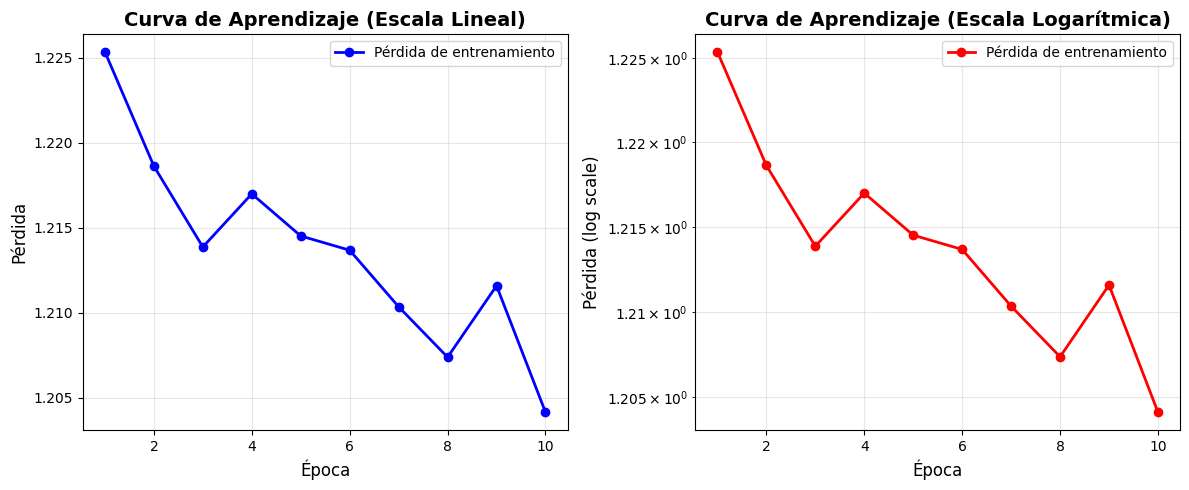

✓ Gráfico guardado como: 'training_convergence.png'


In [18]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(epochs, batch_size=4, save_interval=5):
    """
    Entrenar el modelo con monitoreo completo de convergencia
    
    Args:
        epochs: Número de épocas
        batch_size: Tamaño de batch (reducido para CPU)
        save_interval: Guardar modelo cada N épocas
    """
    import psutil
    import os
    
    model.train()
    best_loss = float('inf')
    
    # Listas para guardar histórico de pérdidas
    history_loss = []
    history_epochs = []
    
    print("=" * 70)
    print(f"CONFIGURACIÓN DE ENTRENAMIENTO")
    print("=" * 70)
    print(f"Dispositivo: {device}")
    print(f"Batch size: {batch_size}")
    print(f"Total de épocas: {epochs}")
    print(f"Total de imágenes: {len(train_dataset)}")
    print(f"Batches por época: {len(train_dataset) // batch_size}")
    print("=" * 70)
    print()
    
    # Crear DataLoader con nuevo batch size
    train_loader_optimized = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )
    
    for epoch in range(epochs):
        epoch_loss = 0
        batch_losses = []
        batch_count = 0
        
        # Barra de progreso
        pbar = tqdm(train_loader_optimized, desc=f"Época {epoch+1}/{epochs}", unit="batch")
        
        for batch_idx, (images, masks) in enumerate(pbar):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            batch_losses.append(batch_loss)
            epoch_loss += batch_loss
            batch_count += 1
            
            # Actualizar barra de progreso
            pbar.set_postfix({'Loss': f'{batch_loss:.4f}'})

        avg_loss = epoch_loss / batch_count
        min_batch_loss = min(batch_losses)
        max_batch_loss = max(batch_losses)
        
        # Guardar histórico
        history_loss.append(avg_loss)
        history_epochs.append(epoch + 1)
        
        # Mostrar información detallada por época
        print()
        print(f"{'─' * 70}")
        print(f"ÉPOCA {epoch+1}/{epochs}")
        print(f"{'─' * 70}")
        print(f"  Pérdida promedio:        {avg_loss:.6f}")
        print(f"  Pérdida mínima (batch):  {min_batch_loss:.6f}")
        print(f"  Pérdida máxima (batch):  {max_batch_loss:.6f}")
        print(f"  Rango de pérdidas:       {max_batch_loss - min_batch_loss:.6f}")
        
        # Calcular tasa de cambio (convergencia)
        if epoch > 0:
            prev_loss = history_loss[epoch - 1]
            loss_change = prev_loss - avg_loss
            loss_change_pct = (loss_change / prev_loss * 100) if prev_loss != 0 else 0
            print(f"  Cambio de pérdida:       {loss_change:+.6f} ({loss_change_pct:+.2f}%)")
            
            if loss_change > 0:
                print(f"  Estado:                  ✓ MEJORANDO (convergiendo)")
            elif loss_change < 0:
                print(f"  Estado:                  ✗ EMPEORANDO (divergiendo)")
            else:
                print(f"  Estado:                  ≈ ESTABLE (sin cambios)")
        else:
            print(f"  Estado:                  → Primera época (comparación la próxima)")
        
        # Guardar mejor modelo y checkpoints
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), '../cloud_segmentation_model_best.pth')
            print(f"  Guardado:                ★ MEJOR MODELO (best.pth)")
        
        if (epoch + 1) % save_interval == 0:
            torch.save(model.state_dict(), f'../cloud_segmentation_model_epoch_{epoch+1}.pth')
            print(f"  Guardado:                ✓ Checkpoint (epoch_{epoch+1}.pth)")
        
        print(f"{'─' * 70}")
        print()

    # GUARDAR EL MODELO FINAL
    torch.save(model.state_dict(), '../cloud_segmentation_model_final.pth')
    print("\n" + "=" * 70)
    print("ENTRENAMIENTO COMPLETADO")
    print("=" * 70)
    print(f"✓ Modelo final guardado como: 'cloud_segmentation_model_final.pth'")
    print(f"✓ Mejor modelo guardado como: 'cloud_segmentation_model_best.pth'")
    print(f"✓ Pérdida inicial: {history_loss[0]:.6f}")
    print(f"✓ Pérdida final: {history_loss[-1]:.6f}")
    print(f"✓ Mejora total: {history_loss[0] - history_loss[-1]:+.6f}")
    print("=" * 70)
    print()
    
    # Graficar curva de aprendizaje
    print("Generando gráfico de convergencia...")
    plt.figure(figsize=(12, 5))
    
    # Gráfico 1: Pérdida por época (escala lineal)
    plt.subplot(1, 2, 1)
    plt.plot(history_epochs, history_loss, 'b-o', linewidth=2, markersize=6, label='Pérdida de entrenamiento')
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Pérdida', fontsize=12)
    plt.title('Curva de Aprendizaje (Escala Lineal)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Gráfico 2: Pérdida por época (escala logarítmica)
    plt.subplot(1, 2, 2)
    plt.semilogy(history_epochs, history_loss, 'r-o', linewidth=2, markersize=6, label='Pérdida de entrenamiento')
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Pérdida (log scale)', fontsize=12)
    plt.title('Curva de Aprendizaje (Escala Logarítmica)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, which='both')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('../training_convergence.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Gráfico guardado como: 'training_convergence.png'")
    
    return history_epochs, history_loss

print("RECOMENDACIONES PARA TU EQUIPO:")
print("=" * 70)
print("1. ✓ Batch size: 4 (optimizado para CPU)")
print("2. ✓ Monitoreo: Verás pérdida por época y cambio de convergencia")
print("3. ✓ Si % es negativo → divergiendo (ajusta learning rate)")
print("4. ✓ Si % es positivo → convergiendo (está aprendiendo)")
print("5. ✓ Gráficos se guardarán en 'training_convergence.png'")
print("=" * 70)
print()

# Ejecutar entrenamiento con monitoreo completo
epochs_hist, loss_hist = train_model(epochs=10, batch_size=4, save_interval=3)

Dataset de prueba: 129 imágenes

Evaluando modelo en datos de prueba...


Evaluación: 100%|██████████| 33/33 [00:24<00:00,  1.34batch/s]


✓ Evaluación completada

RESULTADOS DE EVALUACIÓN - SEGMENTACIÓN DE NUBES
  IoU_nubes........... 0.2912
  IoU_no_nubes........ 0.0000
  mIoU................ 0.1456
  Dice_nubes.......... 0.4510
  Precision........... 0.2912
  Recall.............. 1.0000
  F1_Score............ 0.4510
  Specificity......... 0.0000
  Accuracy............ 0.2912

Matriz de Confusión:
  TP (Verdaderos Positivos): 2461562
  FP (Falsos Positivos):     5992582
  FN (Falsos Negativos):     0
  TN (Verdaderos Negativos): 0



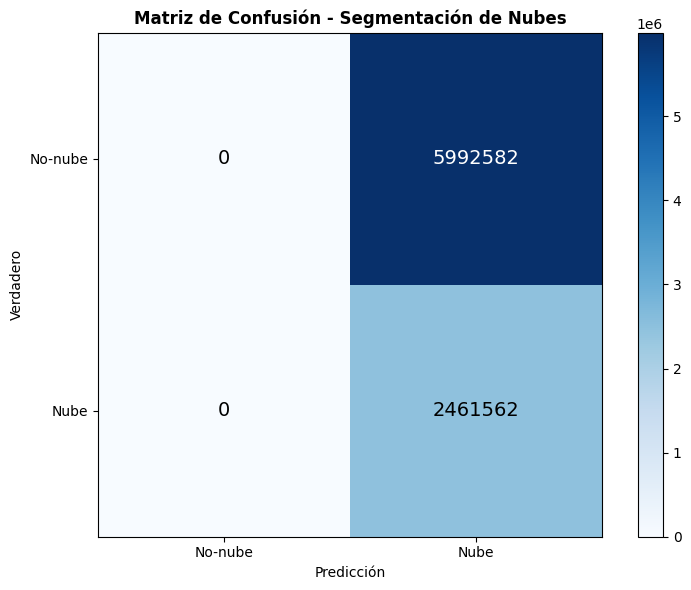

✓ Matriz de confusión guardada en 'confusion_matrix.png'


In [20]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def evaluate_cloud_segmentation(model, test_loader, device='cpu', threshold=0.5):
    """
    Evalúa modelo de segmentación de nubes con métricas completas
    
    Args:
        model: Modelo entrenado
        test_loader: DataLoader con datos de prueba
        device: Dispositivo (cpu o cuda)
        threshold: Umbral para binarizar predicciones
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    print("Evaluando modelo en datos de prueba...")
    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Evaluación", unit="batch")
        
        for images, masks in pbar:
            # images: (B, C, H, W), masks: (B, 1, H, W)
            images = images.to(device)
            masks = masks.to(device)
            
            # Predicciones del modelo
            masks_pred = model(images)  # (B, 1, H, W)
            masks_pred = torch.sigmoid(masks_pred)  # Probabilidades [0, 1]
            masks_pred_binary = (masks_pred > threshold).float()  # Binario
            
            # Aplanar para métricas (píxel por píxel)
            all_preds.extend(masks_pred_binary.cpu().numpy().flatten())
            all_targets.extend(masks.cpu().numpy().flatten())
    
    all_preds = np.array(all_preds).astype(int)
    all_targets = np.array(all_targets).astype(int)
    
    print("✓ Evaluación completada")
    print()
    
    # Calcular matriz de confusión
    tp = np.sum((all_preds == 1) & (all_targets == 1))
    fp = np.sum((all_preds == 1) & (all_targets == 0))
    fn = np.sum((all_preds == 0) & (all_targets == 1))
    tn = np.sum((all_preds == 0) & (all_targets == 0))
    
    # Métricas por píxel
    # IoU (Intersection over Union)
    iou_cloud = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    iou_no_cloud = tn / (tn + fp + fn) if (tn + fp + fn) > 0 else 0
    mean_iou = (iou_cloud + iou_no_cloud) / 2
    
    # Dice (F1)
    dice_cloud = 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) > 0 else 0
    
    # Precision y Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metrics = {
        'IoU_nubes': iou_cloud,
        'IoU_no_nubes': iou_no_cloud,
        'mIoU': mean_iou,
        'Dice_nubes': dice_cloud,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Specificity': specificity,
        'Accuracy': accuracy
    }
    
    return metrics, (tp, fp, fn, tn), (all_preds, all_targets)

# Crear test_loader
test_dataset = CloudDataset(
    images_dir="../data/overall-mask_test", 
    masks_dir="../data/masked_test", 
    size=(256, 256)
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0
)

print(f"Dataset de prueba: {len(test_dataset)} imágenes")
print()

# Evaluar
metrics, confusion, predictions = evaluate_cloud_segmentation(
    model, 
    test_loader, 
    device=device, 
    threshold=0.5
)

# Mostrar resultados
print("=" * 70)
print("RESULTADOS DE EVALUACIÓN - SEGMENTACIÓN DE NUBES")
print("=" * 70)

for metric_name, value in metrics.items():
    print(f"  {metric_name:.<20} {value:.4f}")

print("=" * 70)

tp, fp, fn, tn = confusion
print(f"\nMatriz de Confusión:")
print(f"  TP (Verdaderos Positivos): {tp}")
print(f"  FP (Falsos Positivos):     {fp}")
print(f"  FN (Falsos Negativos):     {fn}")
print(f"  TN (Verdaderos Negativos): {tn}")
print()

# Visualizar matriz de confusión
cm = np.array([[tn, fp], [fn, tp]])
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Segmentación de Nubes', fontweight='bold')
plt.colorbar()
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No-nube', 'Nube'])
plt.yticks(tick_marks, ['No-nube', 'Nube'])

# Añadir valores en la matriz
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center", 
                color="white" if cm[i, j] > cm.max() / 2 else "black", fontsize=14)

plt.tight_layout()
plt.savefig('../confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Matriz de confusión guardada en 'confusion_matrix.png'")



VISUALIZACIÓN CON MUESTRAS ALEATORIAS
Columna 0: Imagen RGB original
Columna 1: Máscara verdadera
Columna 2: Probabilidades del modelo (sin umbral)
Columna 3: Predicción binaria (umbralizada)
Columna 4: Overlay - ROJO=Verdadero, AZUL=Predicción

Generando visualizaciones con muestras aleatorias...
Índices seleccionados: [49, 13, 46, 0]


────────────────────────────────────────────────────────────
Muestra 1/4 - Índice: 49
────────────────────────────────────────────────────────────
Probabilidades: min=0.6078, max=0.6285, media=0.6106
Píxeles de nube predichos: 100.0%
Matriz confusión: TP=25528, FP=40008, FN=0, TN=0
IoU (Jaccard): 0.3895

────────────────────────────────────────────────────────────
Muestra 2/4 - Índice: 13
────────────────────────────────────────────────────────────
Probabilidades: min=0.5136, max=0.7263, media=0.6164
Píxeles de nube predichos: 100.0%
Matriz confusión: TP=5575, FP=59961, FN=0, TN=0
IoU (Jaccard): 0.0851

────────────────────────────────────────────────

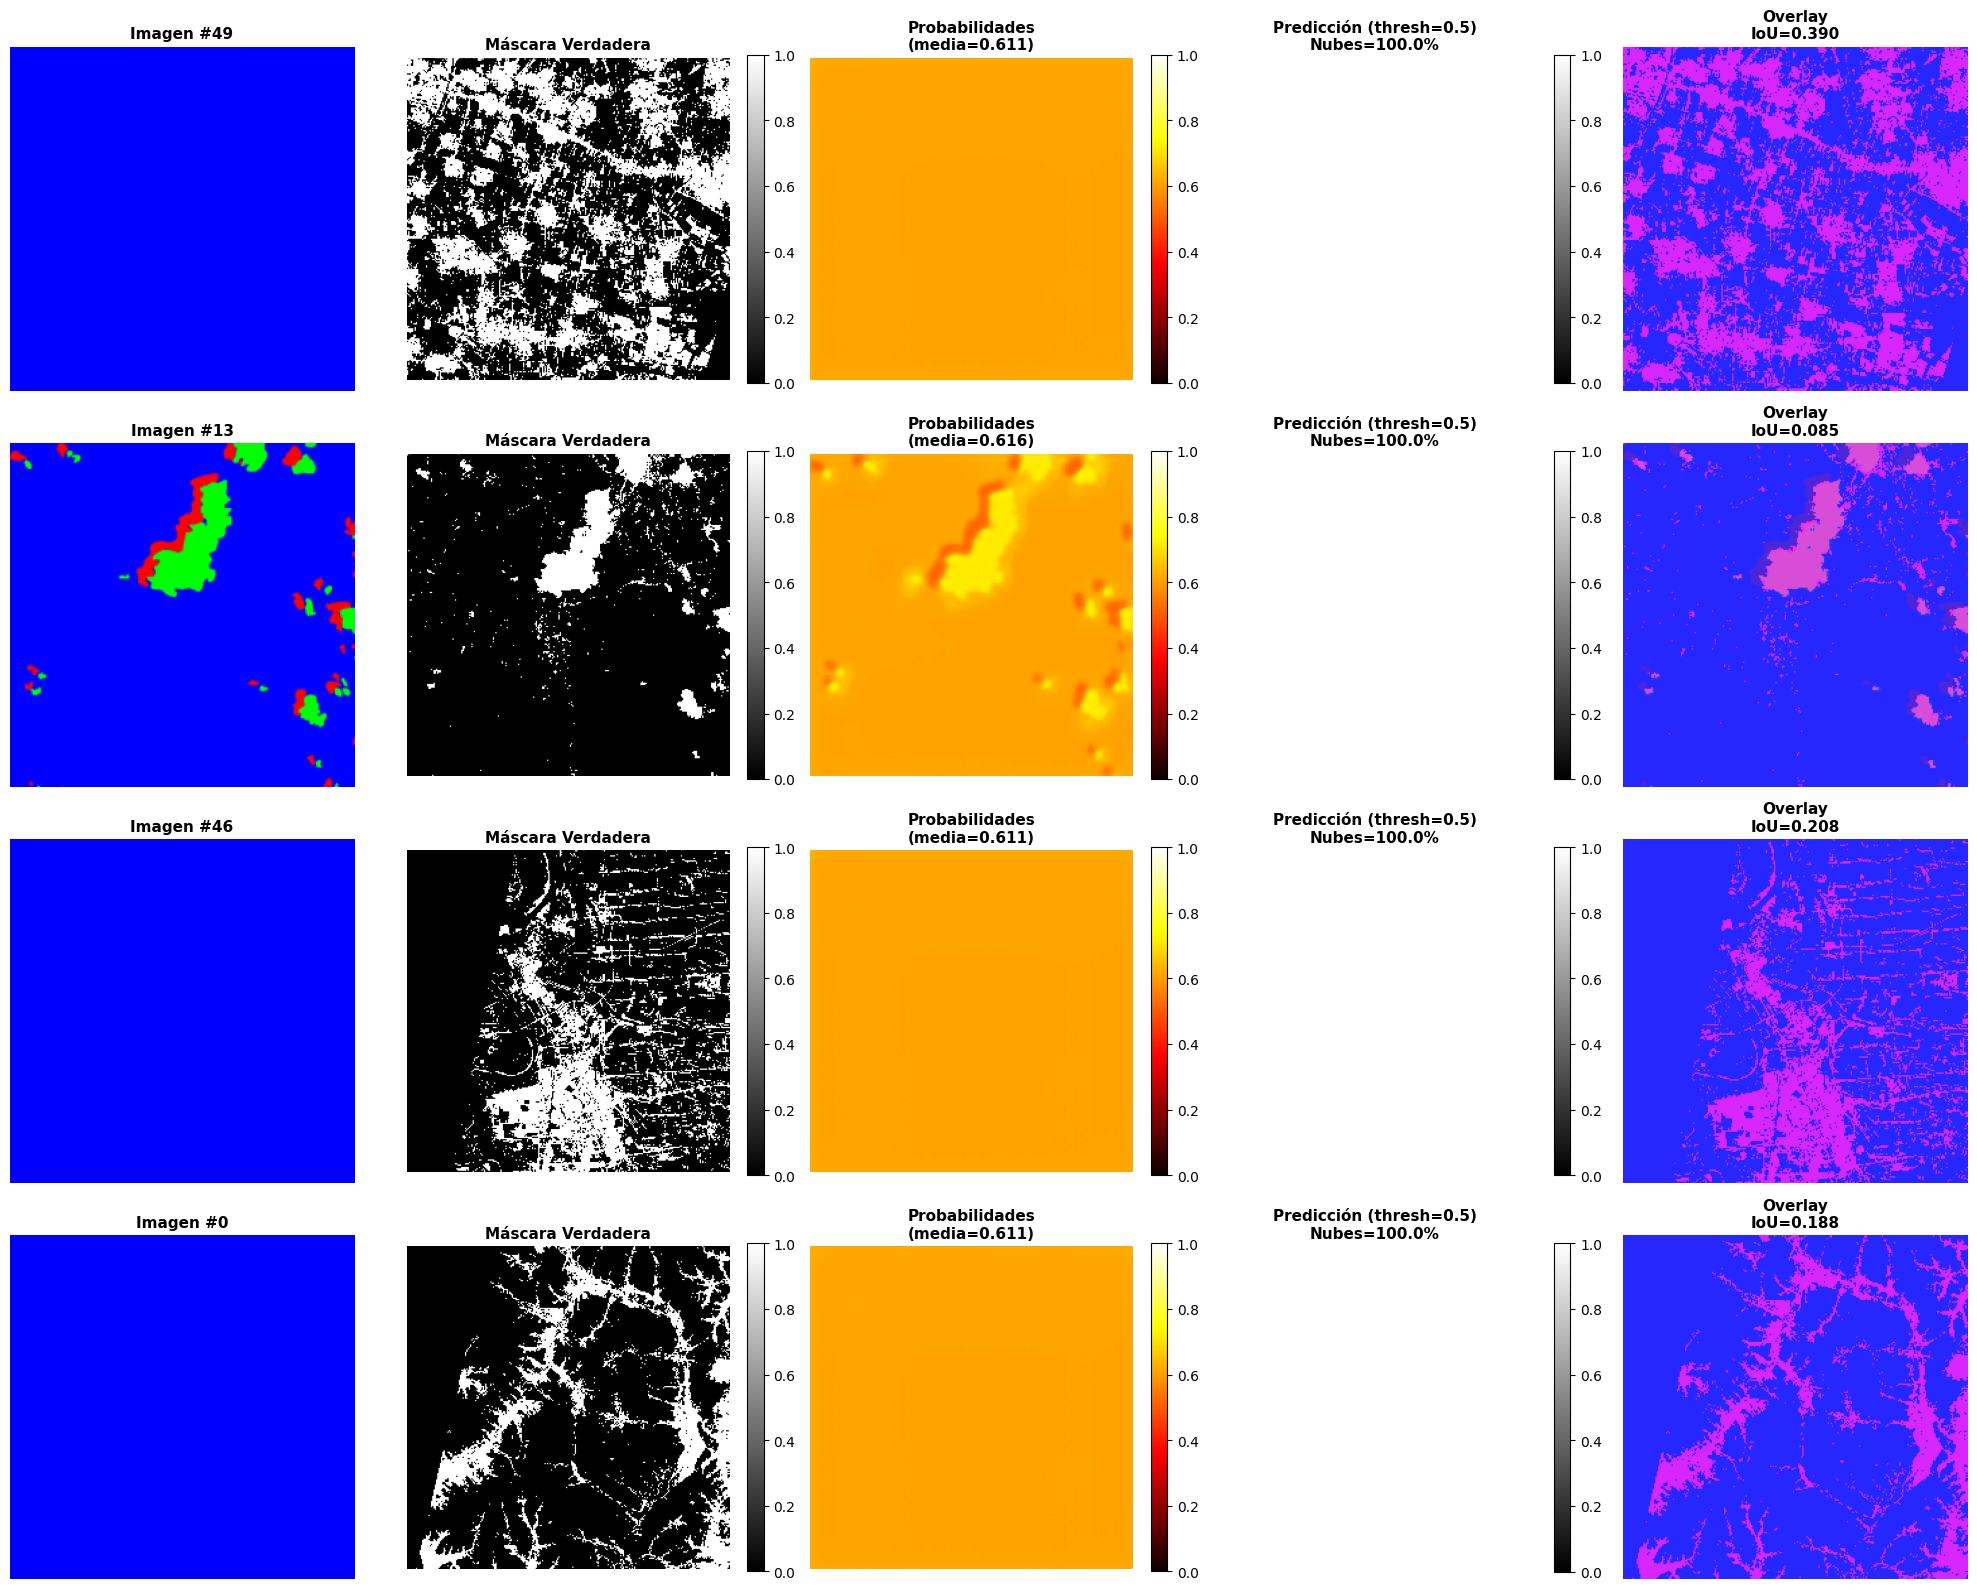

In [27]:
import random

def visualize_predictions(model, test_loader, device='cpu', n_samples=4, threshold=0.5):
    """
    Visualiza predicciones del modelo lado a lado
    
    Args:
        model: Modelo entrenado
        test_loader: DataLoader de prueba
        device: cpu o cuda
        n_samples: Número de muestras a visualizar
        threshold: Umbral para binarizar predicciones
    """
    model.eval()
    
    # Recolectar todos los batches primero
    all_images = []
    all_masks = []
    for images, masks in test_loader:
        all_images.append(images)
        all_masks.append(masks)
    
    # Concatenar todos los batches
    all_images = torch.cat(all_images, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    
    # Seleccionar índices aleatorios
    total_samples = len(all_images)
    random_indices = random.sample(range(total_samples), min(n_samples, total_samples))
    
    # Crear figura con más columnas
    fig, axes = plt.subplots(n_samples, 5, figsize=(20, 4*n_samples))
    
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    print("Generando visualizaciones con muestras aleatorias...")
    print(f"Índices seleccionados: {random_indices}")
    print()
    
    for plot_idx, sample_idx in enumerate(random_indices):
        image = all_images[sample_idx].to(device).unsqueeze(0)  # (1, C, H, W)
        mask_true = all_masks[sample_idx][0].cpu().numpy()  # (H, W)
        
        # Predicción (obtener probabilidades)
        with torch.no_grad():
            mask_pred_prob = torch.sigmoid(model(image))  # (1, 1, H, W)
            mask_pred_prob = mask_pred_prob.squeeze().cpu().numpy()  # (H, W)
        
        mask_pred_binary = (mask_pred_prob > threshold).astype(float)
        
        # Denormalizar imagen para visualización
        img_denorm = image.squeeze().cpu()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_denorm = (img_denorm * std + mean).permute(1, 2, 0)
        img_denorm = torch.clamp(img_denorm, 0, 1).numpy()
        
        row = plot_idx
        
        # Columna 0: Imagen RGB
        axes[row, 0].imshow(img_denorm)
        axes[row, 0].set_title(f'Imagen #{sample_idx}', fontweight='bold', fontsize=11)
        axes[row, 0].axis('off')
        
        # Columna 1: Máscara verdadera
        im1 = axes[row, 1].imshow(mask_true, cmap='gray', vmin=0, vmax=1)
        axes[row, 1].set_title('Máscara Verdadera', fontweight='bold', fontsize=11)
        axes[row, 1].axis('off')
        plt.colorbar(im1, ax=axes[row, 1], fraction=0.046)
        
        # Columna 2: Probabilidades (sin binarizar)
        im2 = axes[row, 2].imshow(mask_pred_prob, cmap='hot', vmin=0, vmax=1)
        prob_mean = mask_pred_prob.mean()
        axes[row, 2].set_title(f'Probabilidades\n(media={prob_mean:.3f})', fontweight='bold', fontsize=11)
        axes[row, 2].axis('off')
        plt.colorbar(im2, ax=axes[row, 2], fraction=0.046)
        
        # Columna 3: Predicción binarizada
        im3 = axes[row, 3].imshow(mask_pred_binary, cmap='gray', vmin=0, vmax=1)
        nube_pixels = (mask_pred_binary > 0.5).sum()
        nube_pct = (nube_pixels / mask_pred_binary.size) * 100
        axes[row, 3].set_title(f'Predicción (thresh={threshold})\nNubes={nube_pct:.1f}%', fontweight='bold', fontsize=11)
        axes[row, 3].axis('off')
        plt.colorbar(im3, ax=axes[row, 3], fraction=0.046)
        
        # Columna 4: Overlay (Rojo=Verdadero, Azul=Predicción)
        overlay = np.zeros((*mask_true.shape, 3))
        overlay[mask_true > 0.5, 0] = 1  # Rojo = Verdadero
        overlay[mask_pred_binary > 0.5, 2] = 1  # Azul = Predicción
        
        # Contar coincidencias
        tp = np.sum((mask_pred_binary > 0.5) & (mask_true > 0.5))
        fp = np.sum((mask_pred_binary > 0.5) & (mask_true <= 0.5))
        fn = np.sum((mask_pred_binary <= 0.5) & (mask_true > 0.5))
        tn = np.sum((mask_pred_binary <= 0.5) & (mask_true <= 0.5))
        
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        
        axes[row, 4].imshow(img_denorm, alpha=0.5)
        axes[row, 4].imshow(overlay, alpha=0.7)
        axes[row, 4].set_title(f'Overlay\nIoU={iou:.3f}', fontweight='bold', fontsize=11)
        axes[row, 4].axis('off')
        
        # Mostrar información en consola
        print(f"\n{'─'*60}")
        print(f"Muestra {plot_idx+1}/{n_samples} - Índice: {sample_idx}")
        print(f"{'─'*60}")
        print(f"Probabilidades: min={mask_pred_prob.min():.4f}, max={mask_pred_prob.max():.4f}, media={prob_mean:.4f}")
        print(f"Píxeles de nube predichos: {nube_pct:.1f}%")
        print(f"Matriz confusión: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
        print(f"IoU (Jaccard): {iou:.4f}")
    
    plt.tight_layout()
    plt.savefig('../cloud_segmentation_results.png', dpi=150, bbox_inches='tight')
    print(f"\n{'─'*60}")
    print("✓ Gráfico guardado como 'cloud_segmentation_results.png'")
    print("✓ Colores overlay: ROJO=Verdadero, AZUL=Predicción, MAGENTA=Coincidencia")
    plt.show()

print("\n" + "="*70)
print("VISUALIZACIÓN CON MUESTRAS ALEATORIAS")
print("="*70)
print("Columna 0: Imagen RGB original")
print("Columna 1: Máscara verdadera")
print("Columna 2: Probabilidades del modelo (sin umbral)")
print("Columna 3: Predicción binaria (umbralizada)")
print("Columna 4: Overlay - ROJO=Verdadero, AZUL=Predicción")
print("="*70 + "\n")

visualize_predictions(model, test_loader, device=device, n_samples=4, threshold=0.5)

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet34
from torch.utils.data import DataLoader
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
import numpy as np

class CloudSegmentationUNet(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = resnet34(pretrained=True)
        self.encoder = nn.Sequential(*list(backbone.children())[:-2])
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)  
        )
    
    def forward(self, x):  
        features = self.encoder(x)
        mask = self.decoder(features) 
        return mask  


def train_cloud_segmentation(seg_model, train_loader, num_epochs=20, device='cpu'):
    """
    Entrenamiento completo para segmentación de nubes
    """

    optimizer = torch.optim.AdamW(seg_model.parameters(), lr=3e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    criterion = nn.BCEWithLogitsLoss()
    
    liveloss = PlotLosses(outputs=[MatplotlibPlot()])
    best_loss = float('inf')
    
    print(f"Batches por época: {len(train_loader)}")
    
    for epoch in range(num_epochs):
        seg_model.train()
        running_loss = 0.0
        n_batches = 0
        
        for batch_idx, batch in enumerate(train_loader):
            # Datos
            inputs = batch["input"].to(device)      
            masks_gt = batch["mask"].to(device)    
            
            # Forward
            masks_pred = seg_model(inputs)          
            loss = criterion(masks_pred, masks_gt)  
            
            # Backward + optimización
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(seg_model.parameters(), max_norm=1.0)  
            optimizer.step()
            
            running_loss += loss.item()
            n_batches += 1
            
            del inputs, masks_gt, masks_pred, loss
            if device == 'cuda':
                torch.cuda.empty_cache()
        
        epoch_loss = running_loss / n_batches
        scheduler.step(epoch_loss)
        
        # Guardar mejor modelo
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(seg_model.state_dict(), 'best_cloud_segmentation.pth')
        
        # Live plot
        logs = {'loss': epoch_loss}
        liveloss.update(logs)
        liveloss.send()
        
        print(f"Época {epoch+1}/{num_epochs}")
        print(f"  Loss: {epoch_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
        print(f"  Mejor loss: {best_loss:.4f}")
    
    # Guardar modelo final
    torch.save(seg_model.state_dict(), 'cloud_segmentation_final.pth')
    print("ENTRENAMIENTO COMPLETADO")
    print(f" Modelos guardados: best_cloud_segmentation.pth | cloud_segmentation_final.pth")

def evaluate_cloud_segmentation(seg_model, test_loader, device='cpu', threshold=0.5):
    """Métricas completas segmentación nubes"""
    seg_model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch["input"].to(device)
            masks_gt = batch["mask"].to(device)
            
            masks_pred = seg_model(inputs)              # logits
            masks_pred = torch.sigmoid(masks_pred)      # probabilidades
            masks_pred_bin = (masks_pred > threshold).float()
            
            all_preds.extend(masks_pred_bin.cpu().numpy().flatten())
            all_targets.extend(masks_gt.cpu().numpy().flatten())
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    # Matriz de confusión
    tp = np.sum((all_preds == 1) & (all_targets == 1))
    fp = np.sum((all_preds == 1) & (all_targets == 0))
    fn = np.sum((all_preds == 0) & (all_targets == 1))
    tn = np.sum((all_preds == 0) & (all_targets == 0))
    
    # Métricas
    iou_cloud = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    iou_no_cloud = tn / (tn + fp + fn) if (tn + fp + fn) > 0 else 0
    dice_cloud = 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) > 0 else 0
    
    return {
        'IoU_nubes': iou_cloud,
        'IoU_no_nubes': iou_no_cloud,
        'mIoU': (iou_cloud + iou_no_cloud) / 2,
        'Dice_nubes': dice_cloud,
        'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'Recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'Accuracy': (tp + tn) / (tp + tn + fp + fn)
    }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Crear y entrenar modelo
seg_model = CloudSegmentationUNet().to(device)
train_cloud_segmentation(seg_model, train_loader, num_epochs=20, device=device)

# Threshold tuning
print("THRESHOLD TUNING")
for thresh in [0.3, 0.4, 0.5, 0.6]:
    test_metrics = evaluate_cloud_segmentation(seg_model, test_loader, device, thresh)
    print(f"Threshold {thresh}: mIoU={test_metrics['mIoU']:.4f}, Dice={test_metrics['Dice_nubes']:.4f}")

